## Load libraries

In [6]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data
import pickle

# Libraries to cluster data
# from sklearn.cluster import OPTICS
from hdbscan import HDBSCAN

# Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib.cm as cm
from cluster_visualization_helper import (
    visualize_cluster)  # user-defined functions

# Libraries for evaluation
from sklearn import metrics

# Libraries for monitoring operation process
from datetime import datetime
from tqdm import tqdm
from joblib import Memory

## Configurate and declare global variables

In [7]:
os_name = os.name

if os_name == 'nt':
    """Windows platform"""
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"

elif os_name == 'posix':
    """Linux platform"""
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"

INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
RESULT_DIR = BASE_DIR + "RESULTS/"

SEED = 6886
%matplotlib inline

## Import data

In [8]:
# title_embeddings_matrix = np.load(OUTPUT_DIR + "title_embeddings_distance_matrix.npy")
# title_embeddings_matrix.shape

In [9]:
title_embeddings = np.load(OUTPUT_DIR + "title_embeddings.npy")
# Load clean job title dataset from file
title_docs = pd.read_csv(
    OUTPUT_DIR + "clean_title_df.csv",
    converters={
        "job_title_token": ast.literal_eval,
    },
    dtype={
        "job_id": int,
        "job_title": str,
        "job_title_lemma": str,
    }
)

In [10]:
title_embeddings.shape, title_docs.shape

((18992, 300), (18992, 4))

In [11]:
title_docs

,job_id,job_title,job_title_lemma,job_title_token
0,1,Chief Financial Officer,chief financial officer,"[chief, financial, officer]"
1,2,Full-time Community Connections Intern (paid i...,time community connection intern pay internship,"[time, community, connection, intern, pay, int..."
2,3,Country Coordinator,country coordinator,"[country, coordinator]"
3,4,BCC Specialist,bcc specialist,"[bcc, specialist]"
4,5,Software Developer,software developer,"[software, developer]"
...,...,...,...,...
18987,18997,Senior Creative UX/ UI Designer,senior creative ux ui designer,"[senior, creative, ux, ui, designer]"
18988,18998,Category Development Manager,category development manager,"[category, development, manager]"
18989,18999,Operational Marketing Manager,operational marketing manager,"[operational, marketing, manager]"
18990,19000,Head of Online Sales Department,head online sale department,"[head, online, sale, department]"


## Clustering data

### HDBSCAN

In [12]:
def hdbscan_clusterer(X, min_samples, min_cluster_size, memory):
    """Generate clusters using HDBSCAN method
    Hierarchical Density-Based Spatial Clustering of Applications with Noise

    Args:
        X:                 Matrix of features
                             (n_samples, n_features)
        min_samples:       The number of samples in a neighborhood for a point
                             to be considered as a core point
                             (int, default=None)
        min_cluster_size:  The minimum size of clusters
                             (int, default=5)

    Returns:
        Trained clustering model based on X
    """
    clusterer = HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
        algorithm='boruvka_kdtree',
        gen_min_span_tree=True,
        core_dist_n_jobs=8,
        memory=memory,
    )
    clusterer.fit(X)
    return clusterer

In [13]:
# Define search space for tuning hyperparameters
X = title_embeddings
mem = Memory(location=OUTPUT_DIR + "/cachedir")
tuning_result = {
    "n_clusters": [],
    "n_noises": [],
    "min_samples": [],
    "min_cluster_size": [],
    "duration": [],
}
model_list = []
label_list = []
outlier_list = []
exemplar_list = []
min_samples_list = [3, 5, 10, 25, 50]
min_cluster_size_list = [2, 3, 4, 5, 10, 25, 50]
len(min_samples_list) * len(min_cluster_size_list)

35

In [14]:
# Tuning hyperparameter
start_loop_time = datetime.now()
print("Start loop", start_loop_time.strftime("%Y-%m-%d %H:%M:%S.%f"))

tqdm_bar = tqdm(
    desc="Tuning HDBSCAN Clustering",
    total=len(min_samples_list) * len(min_cluster_size_list),
)
for min_samples in min_samples_list:
    for min_cluster_size in min_cluster_size_list:

        # Train model
        starttime = datetime.now()
        print("Start", starttime.strftime("%Y-%m-%d %H:%M:%S.%f"))
        print('min_samples =', min_samples)
        print('min_cluster_size =', min_cluster_size)

        clusterer = hdbscan_clusterer(X, min_samples, min_cluster_size, mem)

        endtime = datetime.now()
        print("End", endtime.strftime("%Y-%m-%d %H:%M:%S.%f"))
        print("Duration", endtime - starttime)

        # Save model
        pickle.dump(
            clusterer,
            open(
                OUTPUT_DIR
                + "hdbscan/"
                + "title_hdbscan_model_min_samples-"
                + str(min_samples)
                + "_min_cluster_size-"
                + str(min_cluster_size)
                + ".pkl",
                "wb",
            ),
        )

        model_list.append(clusterer)
        labels = clusterer.labels_
        label_list.append(labels)
        outlier_list.append(clusterer.outlier_scores_)
        exemplar_list.append(clusterer.exemplars_)
        tuning_result['duration'].append(round((endtime - starttime).seconds / 60, 4))
        tuning_result['min_samples'].append(min_samples)
        tuning_result['min_cluster_size'].append(min_cluster_size)
        tuning_result['n_noises'].append(np.sum(np.array(labels) == -1, axis=0))
        tuning_result['n_clusters'].append(np.sum(np.unique(labels) != -1, axis=0))

        tqdm_bar.update(1)

tqdm_bar.close()
end_loop_time = datetime.now()
print("End loop", end_loop_time.strftime("%Y-%m-%d %H:%M:%S.%f"))
print("Duration", end_loop_time - start_loop_time)

Tuning HDBSCAN Clustering:   0%|                                                                | 0/35 [00:00<?, ?it/s]

Start loop 2021-05-18 01:07:39.771680
Start 2021-05-18 01:07:39.776657
min_samples = 3
min_cluster_size = 2
________________________________________________________________________________
[Memory] Calling hdbscan.hdbscan_._hdbscan_boruvka_kdtree...
_hdbscan_boruvka_kdtree(array([[-0.450853, ..., -0.195038],
       ...,
       [-0.254014, ...,  0.077708]]), 
3, 1.0, 'euclidean', None, 40, True, True, 8)
_________________________________________hdbscan_boruvka_kdtree - 508.9s, 8.5min
End 2021-05-18 01:16:14.319366
Duration 0:08:34.542709


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:   3%|█▌                                                   | 1/35 [12:27<7:03:30, 747.36s/it]

Start 2021-05-18 01:20:07.147365
min_samples = 3
min_cluster_size = 3
End 2021-05-18 01:20:08.119364
Duration 0:00:00.971999


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:   6%|███                                                  | 2/35 [17:57<4:36:04, 501.94s/it]

Start 2021-05-18 01:25:37.287284
min_samples = 3
min_cluster_size = 4
End 2021-05-18 01:25:39.221353
Duration 0:00:01.934069


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:   9%|████▌                                                | 3/35 [26:06<4:24:29, 495.91s/it]

Start 2021-05-18 01:33:46.030796
min_samples = 3
min_cluster_size = 5
End 2021-05-18 01:33:47.182316
Duration 0:00:01.151520


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  11%|██████                                               | 4/35 [37:45<4:57:42, 576.21s/it]

Start 2021-05-18 01:45:25.345661
min_samples = 3
min_cluster_size = 10
End 2021-05-18 01:45:28.445871
Duration 0:00:03.100210


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  14%|███████▌                                             | 5/35 [49:22<5:09:52, 619.75s/it]

Start 2021-05-18 01:57:02.289999
min_samples = 3
min_cluster_size = 25
End 2021-05-18 01:57:03.854997
Duration 0:00:01.564998


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  17%|████████▋                                          | 6/35 [1:00:39<5:08:57, 639.23s/it]

Start 2021-05-18 02:08:19.334563
min_samples = 3
min_cluster_size = 50
End 2021-05-18 02:08:21.425384
Duration 0:00:02.090821


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  20%|██████████▏                                        | 7/35 [1:11:00<4:55:29, 633.21s/it]

Start 2021-05-18 02:18:40.167738
min_samples = 5
min_cluster_size = 2
________________________________________________________________________________
[Memory] Calling hdbscan.hdbscan_._hdbscan_boruvka_kdtree...
_hdbscan_boruvka_kdtree(array([[-0.450853, ..., -0.195038],
       ...,
       [-0.254014, ...,  0.077708]]), 
5, 1.0, 'euclidean', None, 40, True, True, 8)
_______________________________________hdbscan_boruvka_kdtree - 1665.6s, 27.8min
End 2021-05-18 02:46:30.022474
Duration 0:27:49.854736


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  23%|███████████▍                                      | 8/35 [1:52:54<9:14:20, 1231.87s/it]

Start 2021-05-18 03:00:33.851024
min_samples = 5
min_cluster_size = 3
End 2021-05-18 03:00:42.944044
Duration 0:00:09.093020


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  26%|████████████▊                                     | 9/35 [2:07:03<8:02:00, 1112.34s/it]

Start 2021-05-18 03:14:43.366959
min_samples = 5
min_cluster_size = 4
End 2021-05-18 03:14:45.686497
Duration 0:00:02.319538


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  29%|██████████████▎                                   | 10/35 [2:15:18<6:24:03, 921.73s/it]

Start 2021-05-18 03:22:58.285602
min_samples = 5
min_cluster_size = 5
End 2021-05-18 03:22:59.305611
Duration 0:00:01.020009


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  31%|███████████████▋                                  | 11/35 [2:21:46<5:03:23, 758.50s/it]

Start 2021-05-18 03:29:26.668567
min_samples = 5
min_cluster_size = 10
End 2021-05-18 03:29:27.805563
Duration 0:00:01.136996


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  34%|█████████████████▏                                | 12/35 [2:28:25<4:08:45, 648.94s/it]

Start 2021-05-18 03:36:05.017690
min_samples = 5
min_cluster_size = 25
End 2021-05-18 03:36:05.609129
Duration 0:00:00.591439


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  37%|██████████████████▌                               | 13/35 [2:33:45<3:21:23, 549.25s/it]

Start 2021-05-18 03:41:24.893658
min_samples = 5
min_cluster_size = 50
End 2021-05-18 03:41:25.962647
Duration 0:00:01.068989


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  40%|████████████████████                              | 14/35 [2:39:01<2:47:35, 478.82s/it]

Start 2021-05-18 03:46:40.963980
min_samples = 10
min_cluster_size = 2
________________________________________________________________________________
[Memory] Calling hdbscan.hdbscan_._hdbscan_boruvka_kdtree...
_hdbscan_boruvka_kdtree(array([[-0.450853, ..., -0.195038],
       ...,
       [-0.254014, ...,  0.077708]]), 
10, 1.0, 'euclidean', None, 40, True, True, 8)


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:571: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  (single_linkage_tree, result_min_span_tree) = memory.cache(


________________________________________hdbscan_boruvka_kdtree - 802.8s, 13.4min
End 2021-05-18 04:00:08.626863
Duration 0:13:27.662883


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  43%|█████████████████████▍                            | 15/35 [3:09:57<4:58:01, 894.07s/it]

Start 2021-05-18 04:17:37.368021
min_samples = 10
min_cluster_size = 3
End 2021-05-18 04:17:39.938022
Duration 0:00:02.570001


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  46%|██████████████████████▊                           | 16/35 [3:25:16<4:45:29, 901.54s/it]

Start 2021-05-18 04:32:56.267653
min_samples = 10
min_cluster_size = 4
End 2021-05-18 04:32:58.943645
Duration 0:00:02.675992


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  49%|████████████████████████▎                         | 17/35 [3:39:48<4:27:47, 892.66s/it]

Start 2021-05-18 04:47:28.273559
min_samples = 10
min_cluster_size = 5
End 2021-05-18 04:47:30.784553
Duration 0:00:02.510994


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  51%|█████████████████████████▋                        | 18/35 [3:55:04<4:14:55, 899.73s/it]

Start 2021-05-18 05:02:44.461514
min_samples = 10
min_cluster_size = 10
End 2021-05-18 05:02:47.789758
Duration 0:00:03.328244


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  54%|███████████████████████████▏                      | 19/35 [4:05:57<3:40:08, 825.52s/it]

Start 2021-05-18 05:13:37.097166
min_samples = 10
min_cluster_size = 25
End 2021-05-18 05:13:38.104168
Duration 0:00:01.007002


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  57%|████████████████████████████▌                     | 20/35 [4:13:11<2:57:02, 708.14s/it]

Start 2021-05-18 05:20:51.679188
min_samples = 10
min_cluster_size = 50
End 2021-05-18 05:20:53.479190
Duration 0:00:01.800002


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  60%|██████████████████████████████                    | 21/35 [4:21:37<2:31:03, 647.42s/it]

Start 2021-05-18 05:29:17.524736
min_samples = 25
min_cluster_size = 2
________________________________________________________________________________
[Memory] Calling hdbscan.hdbscan_._hdbscan_boruvka_kdtree...
_hdbscan_boruvka_kdtree(array([[-0.450853, ..., -0.195038],
       ...,
       [-0.254014, ...,  0.077708]]), 
25, 1.0, 'euclidean', None, 40, True, True, 8)
________________________________________hdbscan_boruvka_kdtree - 610.2s, 10.2min
End 2021-05-18 05:39:31.933632
Duration 0:10:14.408896


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  63%|███████████████████████████████▍                  | 22/35 [4:41:06<2:54:11, 803.94s/it]

Start 2021-05-18 05:48:46.458701
min_samples = 25
min_cluster_size = 3
End 2021-05-18 05:48:47.153698
Duration 0:00:00.694997


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  66%|████████████████████████████████▊                 | 23/35 [4:50:26<2:26:08, 730.71s/it]

Start 2021-05-18 05:58:06.360935
min_samples = 25
min_cluster_size = 4
End 2021-05-18 05:58:07.135983
Duration 0:00:00.775048


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  69%|██████████████████████████████████▎               | 24/35 [5:00:17<2:06:16, 688.77s/it]

Start 2021-05-18 06:07:57.308256
min_samples = 25
min_cluster_size = 5
End 2021-05-18 06:07:59.643437
Duration 0:00:02.335181


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  71%|███████████████████████████████████▋              | 25/35 [5:09:49<1:48:58, 653.85s/it]

Start 2021-05-18 06:17:29.704369
min_samples = 25
min_cluster_size = 10
End 2021-05-18 06:17:30.802419
Duration 0:00:01.098050


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  74%|█████████████████████████████████████▏            | 26/35 [5:19:03<1:33:34, 623.82s/it]

Start 2021-05-18 06:26:43.463187
min_samples = 25
min_cluster_size = 25
End 2021-05-18 06:26:44.991276
Duration 0:00:01.528089


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  77%|██████████████████████████████████████▌           | 27/35 [5:28:14<1:20:14, 601.78s/it]

Start 2021-05-18 06:35:53.828540
min_samples = 25
min_cluster_size = 50
End 2021-05-18 06:35:56.072674
Duration 0:00:02.244134


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  80%|████████████████████████████████████████          | 28/35 [5:35:07<1:03:37, 545.33s/it]

Start 2021-05-18 06:42:47.449559
min_samples = 50
min_cluster_size = 2
________________________________________________________________________________
[Memory] Calling hdbscan.hdbscan_._hdbscan_boruvka_kdtree...
_hdbscan_boruvka_kdtree(array([[-0.450853, ..., -0.195038],
       ...,
       [-0.254014, ...,  0.077708]]), 
50, 1.0, 'euclidean', None, 40, True, True, 8)
_________________________________________hdbscan_boruvka_kdtree - 360.1s, 6.0min
End 2021-05-18 06:48:50.187919
Duration 0:06:02.738360


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  83%|█████████████████████████████████████████▍        | 29/35 [5:48:20<1:01:57, 619.51s/it]

Start 2021-05-18 06:56:00.045620
min_samples = 50
min_cluster_size = 3
End 2021-05-18 06:56:00.787667
Duration 0:00:00.742047


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  86%|████████████████████████████████████████████▌       | 30/35 [5:55:31<46:54, 562.94s/it]

Start 2021-05-18 07:03:10.986200
min_samples = 50
min_cluster_size = 4
End 2021-05-18 07:03:11.637265
Duration 0:00:00.651065


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  89%|██████████████████████████████████████████████      | 31/35 [6:02:36<34:46, 521.53s/it]

Start 2021-05-18 07:10:15.898779
min_samples = 50
min_cluster_size = 5
End 2021-05-18 07:10:16.421775
Duration 0:00:00.522996


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  91%|███████████████████████████████████████████████▌    | 32/35 [6:09:50<24:45, 495.30s/it]

Start 2021-05-18 07:17:29.976134
min_samples = 50
min_cluster_size = 10
End 2021-05-18 07:17:30.557138
Duration 0:00:00.581004


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  94%|█████████████████████████████████████████████████   | 33/35 [6:16:54<15:47, 473.97s/it]

Start 2021-05-18 07:24:34.191166
min_samples = 50
min_cluster_size = 25
End 2021-05-18 07:24:34.634162
Duration 0:00:00.442996


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering:  97%|██████████████████████████████████████████████████▌ | 34/35 [6:23:55<07:37, 457.96s/it]

Start 2021-05-18 07:31:34.792514
min_samples = 50
min_cluster_size = 50
End 2021-05-18 07:31:35.693373
Duration 0:00:00.900859


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)
Tuning HDBSCAN Clustering: 100%|████████████████████████████████████████████████████| 35/35 [6:30:48<00:00, 669.96s/it]

End loop 2021-05-18 07:38:28.314181
Duration 6:30:48.542501


In [15]:
tuning_result["silhouette"] = []
tuning_result["silhouette_error"] = []

tqdm_bar = tqdm(desc="Computing Silhouette score", total=len(model_list))
for i, _ in enumerate(model_list):
    try:
        silhouette = metrics.silhouette_score(
            X, label_list[i], sample_size=10000, random_state=SEED, n_jobs=-1
        )
        tuning_result["silhouette_error"].append("None")
    except Exception as e:
        print(e)
        silhouette = -1.1
        tuning_result["silhouette_error"].append(e)
    tuning_result["silhouette"].append(silhouette)
    tqdm_bar.update(1)
tqdm_bar.close()

Computing Silhouette score: 100%|██████████████████████████████████████████████████████| 35/35 [05:59<00:00, 10.28s/it]


In [16]:
tuning_result["calinski_harabasz"] = []
tuning_result["calinski_harabasz_error"] = []

tqdm_bar = tqdm(desc="Computing Calinski Harabasz score", total=len(model_list))
for i, _ in enumerate(model_list):
    try:
        calinski_harabasz = metrics.calinski_harabasz_score(X, label_list[i])
        tuning_result["calinski_harabasz_error"].append("None")
    except Exception as e:
        print(e)
        calinski_harabasz = -1.1
        tuning_result["calinski_harabasz_error"].append(e)
    tuning_result["calinski_harabasz"].append(calinski_harabasz)
    tqdm_bar.update(1)
tqdm_bar.close()

Computing Calinski Harabasz score: 100%|███████████████████████████████████████████████| 35/35 [00:10<00:00,  3.27it/s]


In [17]:
tuning_result["davies_bouldin"] = []
tuning_result["davies_bouldin_error"] = []

tqdm_bar = tqdm(desc="Computing Davies Bouldin score", total=len(model_list))
for i, _ in enumerate(model_list):
    try:
        davies_bouldin = metrics.davies_bouldin_score(X, label_list[i])
        tuning_result["davies_bouldin_error"].append("None")
    except Exception as e:
        print(e)
        davies_bouldin = -1.1
        tuning_result["davies_bouldin_error"].append(e)
    tuning_result["davies_bouldin"].append(davies_bouldin)
    tqdm_bar.update(1)
tqdm_bar.close()

Computing Davies Bouldin score: 100%|██████████████████████████████████████████████████| 35/35 [00:26<00:00,  1.33it/s]


In [18]:
tuning_result["silhouette_corr"] = []
tuning_result["silhouette_corr_error"] = []

tqdm_bar = tqdm(desc="Computing Silhouette (correlation) score", total=len(model_list))
for i, _ in enumerate(model_list):
    try:
        silhouette = metrics.silhouette_score(
            X,
            label_list[i],
            sample_size=10000,
            random_state=SEED,
            n_jobs=-1,
            metric="correlation",
        )
        tuning_result["silhouette_corr_error"].append("None")
    except Exception as e:
        print(e)
        silhouette = -1.1
        tuning_result["silhouette_corr_error"].append(e)
    tuning_result["silhouette_corr"].append(silhouette)
    tqdm_bar.update(1)
tqdm_bar.close()

Computing Silhouette (correlation) score: 100%|████████████████████████████████████████| 35/35 [16:30<00:00, 28.29s/it]


In [19]:
# Display tuning results
tuning_result_df = pd.DataFrame(tuning_result)
tuning_result_df

,n_clusters,n_noises,min_samples,min_cluster_size,duration,silhouette,silhouette_error,calinski_harabasz,calinski_harabasz_error,davies_bouldin,davies_bouldin_error,silhouette_corr,silhouette_corr_error
0,1683,5083,3,2,8.5667,0.465009,None,34.480593,None,1.126486,None,0.0,None
1,1181,5779,3,3,0.0000,0.431744,None,41.190822,None,1.183073,None,0.0,None
2,1085,5974,3,4,0.0167,0.419883,None,42.862423,None,1.186604,None,0.0,None
3,824,6651,3,5,0.0167,0.379375,None,47.731495,None,1.211891,None,0.0,None
4,392,8405,3,10,0.0500,0.265024,None,67.089569,None,1.261910,None,0.0,None
5,126,11204,3,25,0.0167,0.106275,None,116.439101,None,1.271029,None,0.0,None
6,61,12518,3,50,0.0333,0.027678,None,159.880416,None,1.355913,None,0.0,None
7,1507,6113,5,2,27.8167,0.392389,None,30.851725,None,1.073650,None,0.0,None
8,842,7155,5,3,0.1500,0.356474,None,44.612741,None,1.122541,None,0.0,None
9,687,7501,5,4,0.0333,0.340514,None,50.312788,None,1.161720,None,0.0,None


In [20]:
# Save tuning results
tuning_result_df.to_csv(
    RESULT_DIR + "hdbscan/" + "title_hdbscan_tuning_result.csv", index=False
)

In [21]:
# Combine model sets
tuple_objects = (
    model_list,
    label_list,
    outlier_list,
    exemplar_list,
    tuning_result,
)
len(tuple_objects), len(tuple_objects[0])

(5, 35)

In [22]:
# Save tuple of model sets
pickle.dump(
    tuple_objects, open(RESULT_DIR + "hdbscan/" + "title_hdbscan_model_tuning_list.pkl", "wb")
)

## Evaluate cluster performance

In [23]:
# Calculate other validation indices
model_validation = {
    "min_samples": tuning_result["min_samples"],
    "min_cluster_size": tuning_result["min_cluster_size"],
    "n_clusters": tuning_result["n_clusters"],
    "relative_validity": [],
    "cluster_persistence": [],
}

for i in tqdm(range(len(model_list))):
    model = model_list[i]

    # Retrieve relative validity
    """
    float
    A fast approximation of the Density Based Cluster Validity (DBCV) score. 
    The only difference, and the speed, comes from the fact that 
    this relative_validity_ is computed using 
    the mutual- reachability minimum spanning tree, i.e. minimum_spanning_tree_, 
    instead of the all-points minimum spanning tree used in the reference. 
    This score might not be an objective measure of 
    the goodness of clusterering. 
    It may only be used to compare results across 
    different choices of hyper-parameters, therefore is only a relative score.
    """
    relative_validity = model.relative_validity_

    # Retrieve cluster persistence
    """
    ndarray, shape (n_clusters, )
    A score of how persistent each cluster is. 
    A score of 1.0 represents a perfectly stable cluster 
    that persists over all distance scales, 
    while a score of 0.0 represents a perfectly ephemeral cluster. 
    These scores can be gauge the relative coherence 
    of the clusters output by the algorithm.
    """
    cluster_persistence = model.cluster_persistence_

    model_validation["relative_validity"].append(relative_validity)
    model_validation["cluster_persistence"].append(cluster_persistence)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:48<00:00,  1.38s/it]


In [24]:
model_validation_df = pd.DataFrame(
    {
        "min_samples": model_validation["min_samples"],
        "min_cluster_size": model_validation["min_cluster_size"],
        "n_clusters": model_validation["n_clusters"],
        "relative_validity": model_validation["relative_validity"],
    }
)

In [25]:
# Save validation results
model_validation_df.to_csv(
    RESULT_DIR + "hdbscan/" + "title_hdbscan_validation_result.csv", index=False
)

In [26]:
# Combine model sets
tuple_objects2 = (
    model_list,
    label_list,
    outlier_list,
    exemplar_list,
    tuning_result,
    model_validation,
)
len(tuple_objects2), len(tuple_objects2[0])

(6, 35)

In [27]:
# Save tuple
pickle.dump(
    tuple_objects2,
    open(OUTPUT_DIR + "hdbscan/" + "title_hdbscan_tuning_validation_list.pkl", "wb"),
)

#### Number of clusters found

In [28]:
# List of markers for subplots
marker_dict = {
    ".": "point",
    ",": "pixel",
    "o": "circle",
    "v": "triangle_down",
    "^": "triangle_up",
    "<": "triangle_left",
    ">": "triangle_right",
    "1": "tri_down",
    "2": "tri_up",
    "3": "tri_left",
    "4": "tri_right",
    "8": "octagon",
    "s": "square",
    "p": "pentagon",
    "*": "star",
    "h": "hexagon1",
    "H": "hexagon2",
    "+": "plus",
    "x": "x",
    "D": "diamond",
    "d": "thin_diamond",
    "|": "vline",
    "_": "hline",
    "P": "plus_filled",
    "X": "x_filled",
    0: "tickleft",
    1: "tickright",
    2: "tickup",
    3: "tickdown",
    4: "caretleft",
    5: "caretright",
    6: "caretup",
    7: "caretdown",
    8: "caretleftbase",
    9: "caretrightbase",
    10: "caretupbase",
    11: "caretdownbase",
}
marker_list = list(marker_dict.keys())

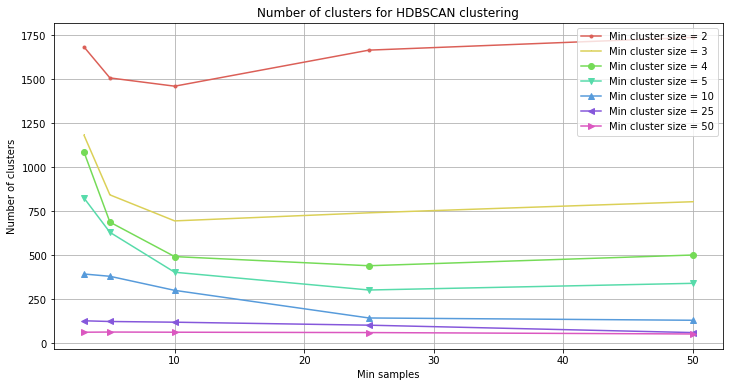

In [42]:
palette = sns.color_palette("hls", n_colors=len(min_cluster_size_list))

# The higher the better
fig = plt.figure(figsize=(12, 6))
for idx, min_cluster_size in enumerate(min_cluster_size_list):
    plt.plot(
        tuning_result_df["min_samples"].loc[
            tuning_result_df["min_cluster_size"] == min_cluster_size
        ],        
        tuning_result_df["n_clusters"].loc[
            tuning_result_df["min_cluster_size"] == min_cluster_size
        ],        
        label="Min cluster size = "
        + str(min_cluster_size),
        color=palette[idx],
        marker=marker_list[idx]
    )
plt.ylabel("Number of clusters")
# plt.yticks(np.unique(model_result_df["number_clusters"]))
plt.xlabel("Min samples")
# plt.xticks(np.unique(model_result_df["min_samples"]))
plt.title("Number of clusters for HDBSCAN clustering")
plt.legend(loc="best")
plt.grid()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "hdbscan/" + "title_hdbscan_n_clusters_plot.png",
#     bbox_inches="tight",
#     dpi=150,
)

# Show plot
plt.show()

#### Silhoulette score

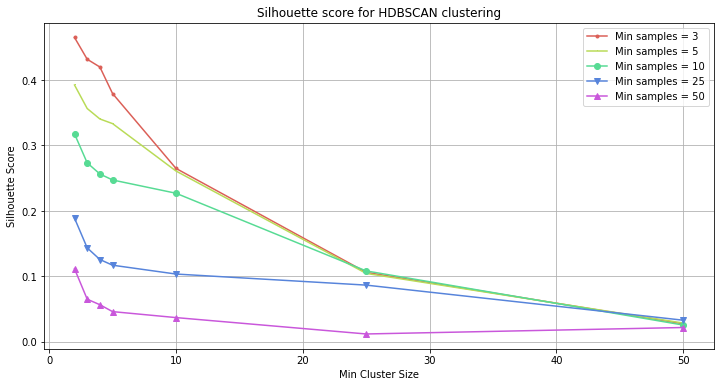

In [30]:
palette = sns.color_palette("hls", n_colors=len(min_samples_list))

# The higher the better
fig, ax1 = plt.subplots(figsize=(12, 6))
for idx, min_samples in enumerate(min_samples_list):
    ax1.plot(
        tuning_result_df["min_cluster_size"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        tuning_result_df["silhouette"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        label="Min samples = "
        + str(min_samples), color=palette[idx],
        marker=marker_list[idx]
    )
ax1.set_xlabel("Min Cluster Size")
# ax1.set_xticks(min_cluster_size_list)
ax1.set_ylabel("Silhouette Score")
ax1.set_title("Silhouette score for HDBSCAN clustering")
ax1.legend(loc="best")
ax1.grid()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "hdbscan/" + "title_hdbscan_silhouette_plot.png",
#     bbox_inches="tight",
#     dpi=150,
)

# Show plot
plt.show()

#### Calinski Harabasz Score

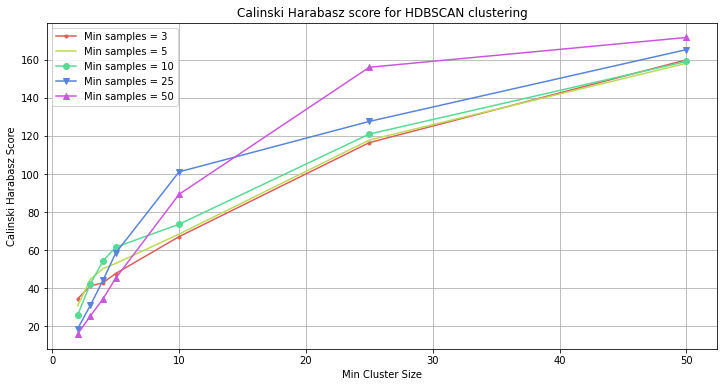

In [31]:
palette = sns.color_palette("hls", n_colors=len(min_samples_list))

# The higher the better
fig, ax1 = plt.subplots(figsize=(12, 6))
for idx, min_samples in enumerate(min_samples_list):
    ax1.plot(
        tuning_result_df["min_cluster_size"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        tuning_result_df["calinski_harabasz"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        label="Min samples = "
        + str(min_samples), color=palette[idx],
        marker=marker_list[idx]
    )
ax1.set_xlabel("Min Cluster Size")
# ax1.set_xticks(min_cluster_size_list)
ax1.set_ylabel("Calinski Harabasz Score")
ax1.set_title("Calinski Harabasz score for HDBSCAN clustering")
ax1.legend(loc="best")
ax1.grid()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "hdbscan/" + "title_hdbscan_calinski_harabasz_plot.png",
#     bbox_inches="tight",
#     dpi=150,
)

# Show plot
plt.show()

#### Davies-Bouldin Score

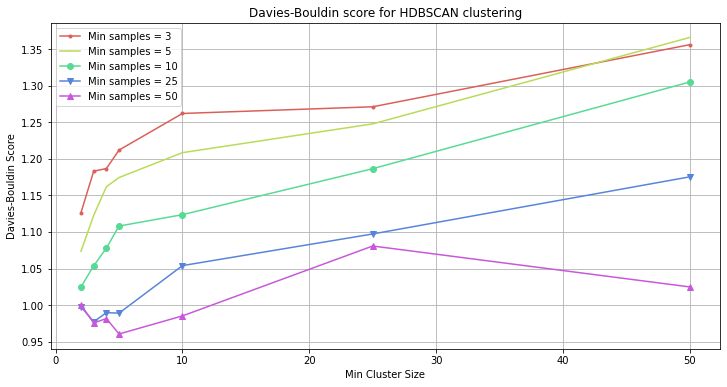

In [32]:
palette = sns.color_palette("hls", n_colors=len(min_samples_list))

# Closer to 0 is better
fig, ax1 = plt.subplots(figsize=(12, 6))
for idx, min_samples in enumerate(min_samples_list):
    ax1.plot(
        tuning_result_df["min_cluster_size"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        tuning_result_df["davies_bouldin"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        label="Min samples = "
        + str(min_samples), color=palette[idx],
        marker=marker_list[idx]
    )
ax1.set_xlabel("Min Cluster Size")
# ax1.set_xticks(min_cluster_size_list)
ax1.set_ylabel("Davies-Bouldin Score")
ax1.set_title("Davies-Bouldin score for HDBSCAN clustering")
ax1.legend(loc="best")
ax1.grid()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "hdbscan/" + "title_hdbscan_davies_bouldin_plot.png",
#     bbox_inches="tight",
#     dpi=150,
)

# Show plot
plt.show()

#### Relative validity

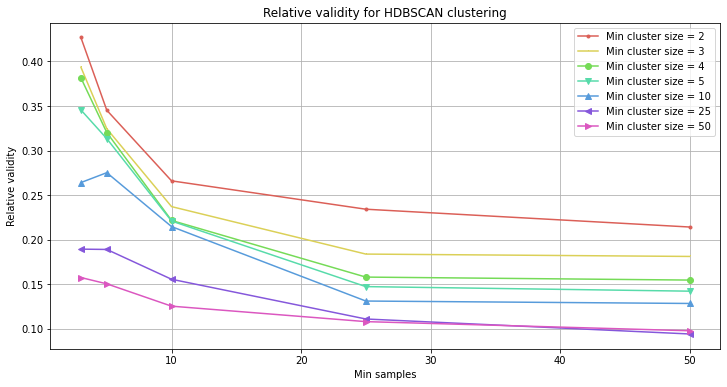

In [33]:
palette = sns.color_palette("hls", n_colors=len(min_cluster_size_list))

# The higher the better
plt.figure(figsize=(12, 6))
for idx, min_cluster_size in enumerate(min_cluster_size_list):
    plt.plot(
        model_validation_df["min_samples"].loc[
            model_validation_df["min_cluster_size"] == min_cluster_size
        ],
        model_validation_df["relative_validity"].loc[
            model_validation_df["min_cluster_size"] == min_cluster_size
        ],
        label="Min cluster size = " + str(min_cluster_size),
        color=palette[idx],
        marker=marker_list[idx]
    )
plt.ylabel("Relative validity")
plt.xlabel("Min samples")
plt.title("Relative validity for HDBSCAN clustering")
plt.legend(loc="best")
plt.grid()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "hdbscan/" + "title_hdbscan_relative-validity_plot.png",
#     bbox_inches="tight",
#     dpi=150,
)

# Show plot
plt.show()

In [60]:
# best_index = np.argmax(model_validation['relative_validity'])
best_index = int(
    np.where(
        (np.array(tuning_result["min_samples"]) == 5)
        & (np.array(tuning_result["min_cluster_size"]) == 50)
    )[0]
)
print(best_index)

best_min_samples = tuning_result_df["min_samples"][best_index]
best_min_cluster_size = tuning_result_df["min_cluster_size"][best_index]
print(best_min_samples, best_min_cluster_size)
best_labels = label_list[best_index]
best_n_clusters = tuning_result_df["n_clusters"][best_index]
best_n_noises = tuning_result_df["n_noises"][best_index]
print(best_n_clusters, best_n_noises)

13
5 50
62 12601


In [35]:
pca_datapoint = np.load(OUTPUT_DIR + "visualization/" + "title_pca_datapoints.npy")
umap_datapoint = np.load(OUTPUT_DIR + "visualization/" + "title_umap_datapoints.npy")
tsne_datapoint = np.load(OUTPUT_DIR + "visualization/" + "title_tsne_datapoints.npy")

Start PCA 2021-05-18 09:29:51.502252
End PCA 2021-05-18 09:29:51.507261
PCA duration 0:00:00.005009

Start t-SNE 2021-05-18 09:29:51.507261
End t-SNE 2021-05-18 09:29:51.513252
t-SNE duration 0:00:00.005991

Start UMAP 2021-05-18 09:29:51.513252
End UMAP 2021-05-18 09:29:51.517271
UMAP duration 0:00:00.004019



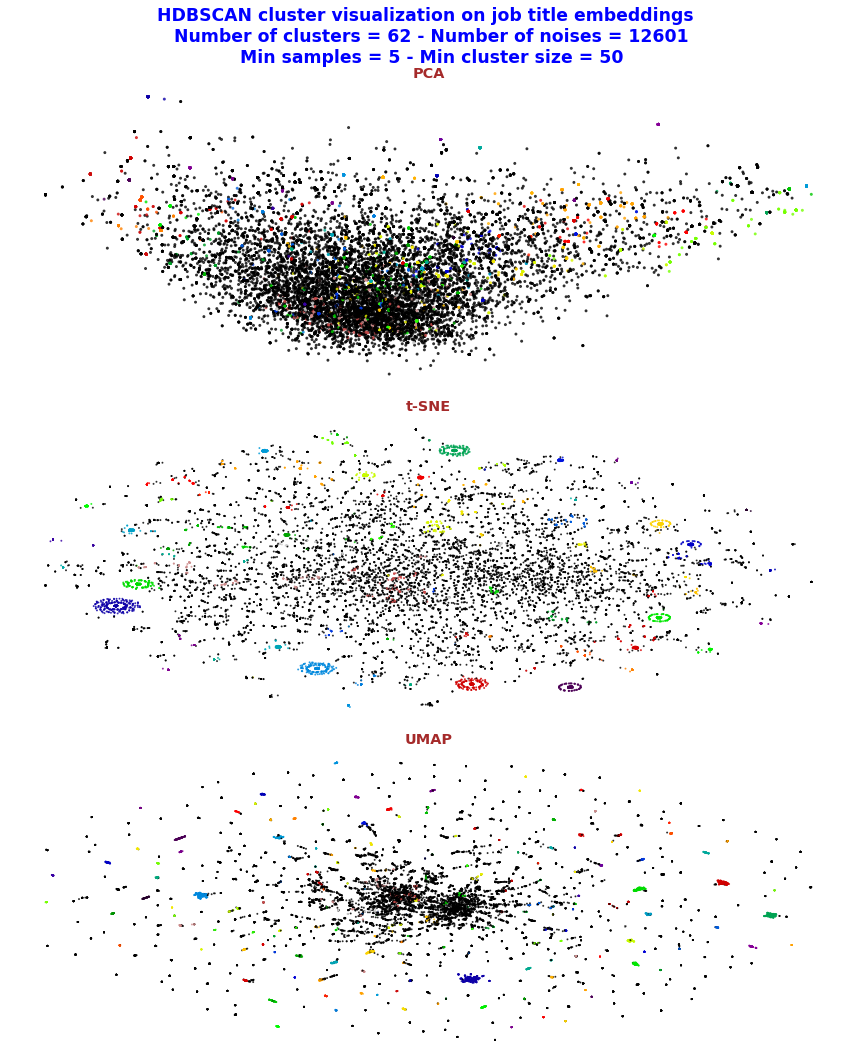

In [61]:
plot_title = (
    "HDBSCAN cluster visualization on job title embeddings \n Number of clusters = "
    + str(best_n_clusters) + " - Number of noises = " + str(best_n_noises)
    + "\n Min samples = "
    + str(best_min_samples)
    + " - Min cluster size = "
    + str(best_min_cluster_size)
)
plot_filename = (
    RESULT_DIR + "hdbscan/" + "title_hdbscan_optimal-cluster-visualization.png"
)
palette = sns.color_palette("nipy_spectral", as_cmap=True)
# colors = cm.nipy_spectral(best_labels.astype(float) / best_k)
colors = best_labels

# Visualize clusters with PCA, UMAP, and t-SNE
visualize_cluster(
    plot_title,
    (12, 15),
    colors,
    palette,
    4,
    pca_datapoint,
    tsne_datapoint,
    umap_datapoint,
    pca=True,
    tsne=True,
    compute_umap=True,
    save_plots=True,
    plot_file=plot_filename,
)

## Display top words of each cluster

In [62]:
df_clusters = title_docs.copy(deep=True)
df_clusters["model_type"] = "hdbscan"
df_clusters["title_n_clusters"] = best_n_clusters
# df_clusters["embeddings"] = "job_title"
df_clusters['title_cluster_label'] = best_labels
df_clusters

,job_id,job_title,job_title_lemma,job_title_token,model_type,title_n_clusters,title_cluster_label
0,1,Chief Financial Officer,chief financial officer,"[chief, financial, officer]",hdbscan,62,58
1,2,Full-time Community Connections Intern (paid i...,time community connection intern pay internship,"[time, community, connection, intern, pay, int...",hdbscan,62,-1
2,3,Country Coordinator,country coordinator,"[country, coordinator]",hdbscan,62,-1
3,4,BCC Specialist,bcc specialist,"[bcc, specialist]",hdbscan,62,-1
4,5,Software Developer,software developer,"[software, developer]",hdbscan,62,25
...,...,...,...,...,...,...,...
18987,18997,Senior Creative UX/ UI Designer,senior creative ux ui designer,"[senior, creative, ux, ui, designer]",hdbscan,62,-1
18988,18998,Category Development Manager,category development manager,"[category, development, manager]",hdbscan,62,-1
18989,18999,Operational Marketing Manager,operational marketing manager,"[operational, marketing, manager]",hdbscan,62,-1
18990,19000,Head of Online Sales Department,head online sale department,"[head, online, sale, department]",hdbscan,62,60


In [63]:
wordcount = {}
sorted_wordcount = {}
for i in range(best_n_clusters):
    titles = df_clusters[df_clusters["title_cluster_label"] == i][
        "job_title_lemma"
    ].values
    titles = " ".join(" ".join(titles).split())
    wordcount[i] = {}
    for j in titles.split():
        if j in wordcount[i]:
            wordcount[i][j] += 1
        else:
            wordcount[i][j] = 1
    sorted_wordcount[i] = sorted(wordcount[i].items(), key=lambda x: x[1], reverse=True)

In [64]:
topwords = {}
for key, i in sorted_wordcount.items():
    print("Cluster "+str(key)+": ", end='')
    topwords[key] = ''
    for newkey, j in sorted_wordcount[key][:10]:
        print(newkey + '|', end='')
        topwords[key] = topwords[key] + newkey + '|'
    print()

Cluster 0: driver|vanadzor|
Cluster 1: lawyer|attorney|vanadzor|
Cluster 2: designer|archhitect|achitect|
Cluster 3: cashier|salesperson|vanadzor|abovyan|
Cluster 4: receptionist|
Cluster 5: programmer|bitrix|
Cluster 6: engineer|martuni|
Cluster 7: specialist|consultant|
Cluster 8: accountant|bookkeeper|stepanavan|
Cluster 9: translator|
Cluster 10: english|language|course|
Cluster 11: language|english|translator|instructor|interpreter|teacher|armenian|native|german|tutor|
Cluster 12: graphic|designer|developer|poligrapher|
Cluster 13: specialist|procurement|contract|department|monitor|management|senior|assistant|lead|deal|
Cluster 14: analyst|financial|business|senior|system|research|market|finance|accountant|department|
Cluster 15: hr|manager|assistant|finance|recruiter|senior|intern|
Cluster 16: medical|representative|gyumri|nagorno|karabakh|vanadzor|shirak|head|tavush|syunik|
Cluster 17: manager|fishfarm|tumo|stepanakert|
Cluster 18: java|developer|
Cluster 19: administrator|syste

## Save cluster results to file

In [65]:
df_clusters.to_csv(
    RESULT_DIR + "hdbscan/" + "title_hdbscan_optimal-cluster-labels.csv", index=False
)

In [66]:
# Save tuple of model sets
pickle.dump(
    (sorted_wordcount, topwords),
    open(RESULT_DIR + "hdbscan/" + "title_hdbscan_optimal-topwords.pkl", "wb"),
)